In [2]:
import numpy as np
import pandas as pd

# 1 year of daily data
dates = pd.date_range("2023-01-01", "2023-12-31", freq="D")
n = len(dates)

base = 100                    #Base demand
trend = np.linspace(0, 20, n) #slowly increasing demand over the year
weekly = 10 * np.sin(2 * np.pi * np.arange(n) / 7) #weekly pattern
noise = np.random.normal(0, 5, n)

demand = base + trend + weekly + noise

df = pd.DataFrame({
    "date": dates,
    "product_id": "SKU-001",
    "demand": np.round(demand).astype(int)
})
df.head()

,date,product_id,demand
0,2023-01-01,SKU-001,105
1,2023-01-02,SKU-001,103
2,2023-01-03,SKU-001,118
3,2023-01-04,SKU-001,88
4,2023-01-05,SKU-001,95


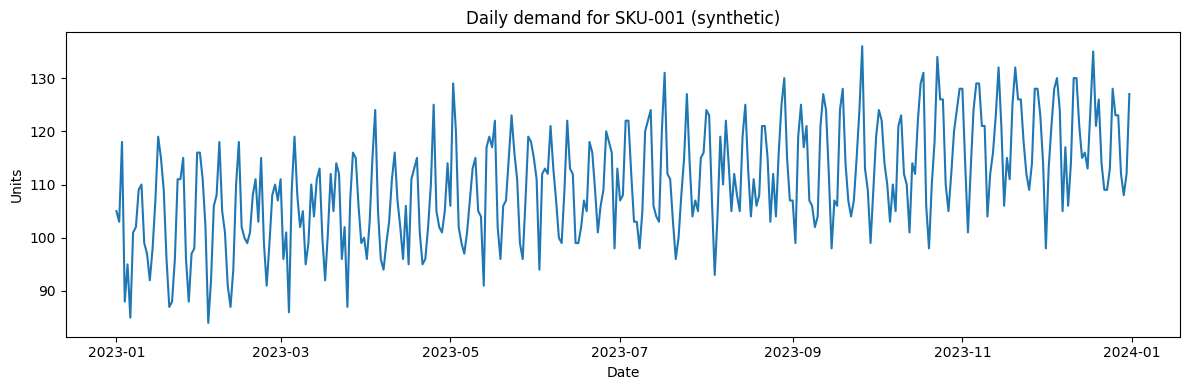

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df["date"], df["demand"])
plt.title("Daily demand for SKU-001 (synthetic)")
plt.xlabel("Date")
plt.ylabel("Units")
plt.tight_layout()
plt.show()


In [ ]:
# Lag feature: yesterday's demand
df["demand_lag1"] = df["demand"].shift(1)

# Moving average of the last 7 days (up to yesterday)
df["demand_ma7"] = df["demand"].rolling(7).mean().shift(1)

df.head(10)




,date,product_id,demand,demand_lag1,demand_ma7
0,2023-01-01,SKU-001,105,NaN,NaN
1,2023-01-02,SKU-001,103,105.0,NaN
2,2023-01-03,SKU-001,118,103.0,NaN
3,2023-01-04,SKU-001,88,118.0,NaN
4,2023-01-05,SKU-001,95,88.0,NaN
5,2023-01-06,SKU-001,85,95.0,NaN
6,2023-01-07,SKU-001,101,85.0,NaN
7,2023-01-08,SKU-001,102,101.0,99.285714
8,2023-01-09,SKU-001,109,102.0,98.857143
9,2023-01-10,SKU-001,110,109.0,99.714286


In [5]:
df2 = df.dropna().reset_index(drop=True)
len(df), len(df2)


(365, 358)

In [6]:
# last 60 days will be our test period
train = df2.iloc[:-60]
test = df2.iloc[-60:]

len(train), len(test)


(298, 60)

In [7]:
from sklearn.metrics import mean_absolute_error

y_test = test["demand"]

# baseline: predict tomorrow's demand as yesterday's demand
pred_lag1 = test["demand_lag1"]

mae_lag1 = mean_absolute_error(y_test, pred_lag1)
mae_lag1


7.983333333333333

In [8]:
pred_ma7 = test["demand_ma7"]

mae_ma7 = mean_absolute_error(y_test, pred_ma7)
mae_lag1, mae_ma7


(7.983333333333333, 7.5476190476190474)

In [9]:
from sklearn.ensemble import RandomForestRegressor

# add day-of-week feature
df2["dow"] = df2["date"].dt.dayofweek

train = df2.iloc[:-60]
test = df2.iloc[-60:]

features = ["demand_lag1", "demand_ma7", "dow"]

X_train = train[features]
y_train = train["demand"]

X_test = test[features]
y_test = test["demand"]

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)
pred_rf = model.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
mae_lag1, mae_ma7, mae_rf


(7.983333333333333, 7.5476190476190474, 4.707555555555556)

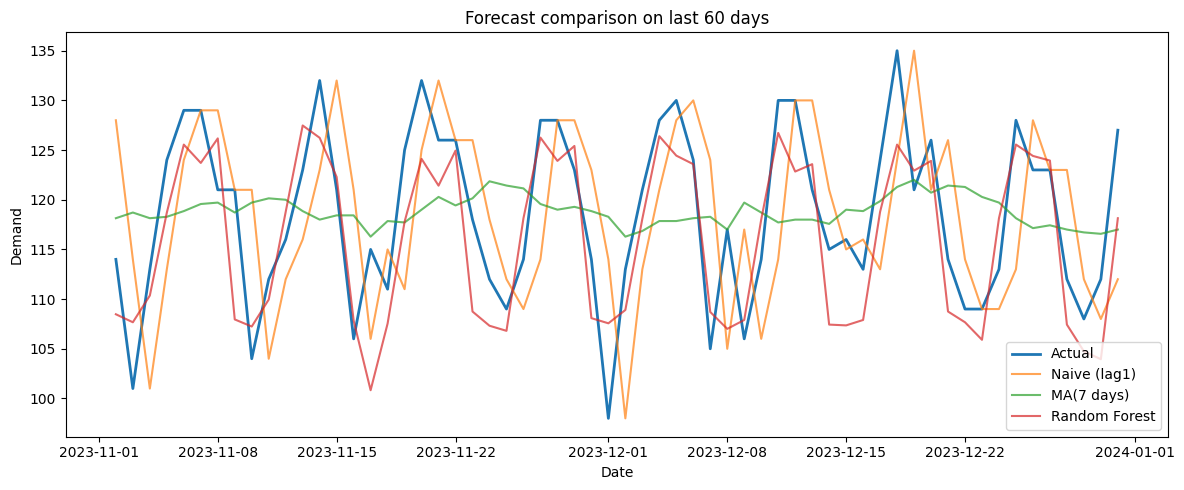

In [10]:
test_plot = test.copy()
test_plot["pred_lag1"] = pred_lag1.values
test_plot["pred_ma7"] = pred_ma7.values
test_plot["pred_rf"] = pred_rf

plt.figure(figsize=(12,5))
plt.plot(test_plot["date"], test_plot["demand"], label="Actual", linewidth=2)
plt.plot(test_plot["date"], test_plot["pred_lag1"], label="Naive (lag1)", alpha=0.7)
plt.plot(test_plot["date"], test_plot["pred_ma7"], label="MA(7 days)", alpha=0.7)
plt.plot(test_plot["date"], test_plot["pred_rf"], label="Random Forest", alpha=0.7)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Forecast comparison on last 60 days")
plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import pandas as pd  # you already imported earlier, but it's fine to re-import

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    eps = 1e-8  # avoid divide-by-zero
    return np.mean(np.abs((y_true - y_pred) / np.maximum(eps, y_true))) * 100

metrics = []

# Naive (lag1)
metrics.append({
    "model": "Naive (lag1)",
    "MAE": mean_absolute_error(y_test, pred_lag1),
    "MAPE": mean_absolute_percentage_error(y_test, pred_lag1)
})

# Moving average 7-day
metrics.append({
    "model": "MA(7 days)",
    "MAE": mean_absolute_error(y_test, pred_ma7),
    "MAPE": mean_absolute_percentage_error(y_test, pred_ma7)
})

# Random Forest
metrics.append({
    "model": "Random Forest",
    "MAE": mean_absolute_error(y_test, pred_rf),
    "MAPE": mean_absolute_percentage_error(y_test, pred_rf)
})

metrics_df = pd.DataFrame(metrics)
metrics_df


,model,MAE,MAPE
0,Naive (lag1),7.983333,6.847876
1,MA(7 days),7.547619,6.466854
2,Random Forest,4.707556,3.992853


In [12]:
# Residuals for each model
test_plot["res_lag1"] = test_plot["demand"] - test_plot["pred_lag1"]
test_plot["res_ma7"] = test_plot["demand"] - test_plot["pred_ma7"]
test_plot["res_rf"] = test_plot["demand"] - test_plot["pred_rf"]

test_plot[["date", "demand", "pred_rf", "res_rf"]].head()


,date,demand,pred_rf,res_rf
298,2023-11-02,114,108.475,5.525
299,2023-11-03,101,107.670,-6.670
300,2023-11-04,113,110.360,2.640
301,2023-11-05,124,118.705,5.295
302,2023-11-06,129,125.550,3.450


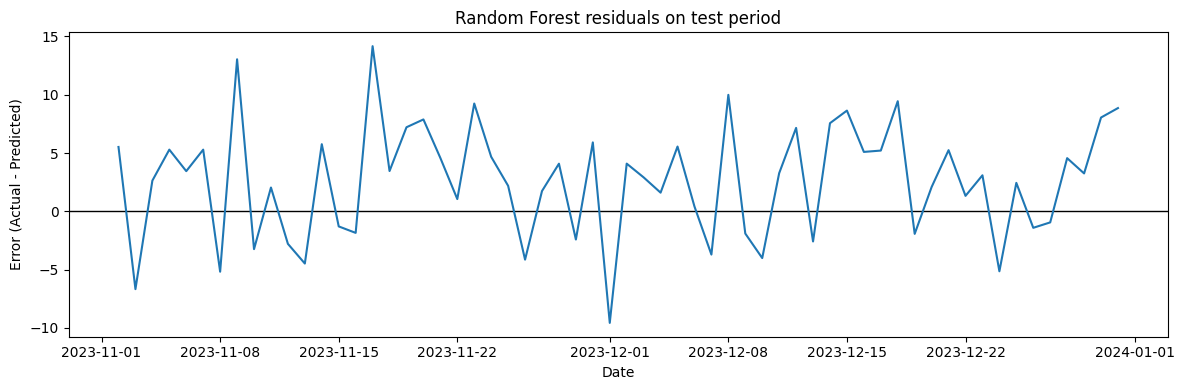

In [13]:
plt.figure(figsize=(12,4))
plt.axhline(0, color="black", linewidth=1)
plt.plot(test_plot["date"], test_plot["res_rf"], label="Residuals (RF)")
plt.xlabel("Date")
plt.ylabel("Error (Actual - Predicted)")
plt.title("Random Forest residuals on test period")
plt.tight_layout()
plt.show()


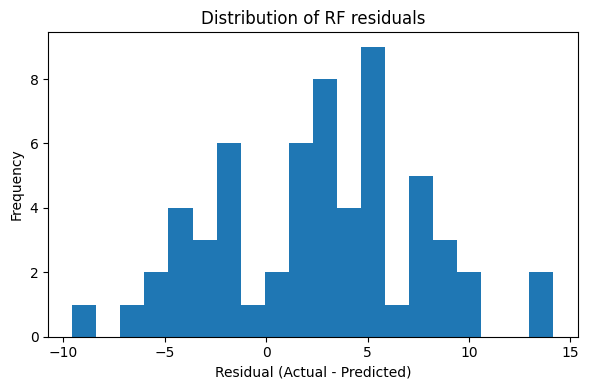

In [14]:
plt.figure(figsize=(6,4))
plt.hist(test_plot["res_rf"], bins=20)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of RF residuals")
plt.tight_layout()
plt.show()


In [15]:
# How many days into the future to predict
horizon = 30

# We'll work with df2 (the one with no NaNs) and keep just what we need
history = df2[["date", "demand", "demand_lag1", "demand_ma7", "dow"]].copy()
history = history.sort_values("date").reset_index(drop=True)

last_date = history["date"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1),
                             last_date + pd.Timedelta(days=horizon),
                             freq="D")

future_rows = []

# We'll simulate forward: each new prediction becomes tomorrow's lag for the next step
temp_history = history.copy()

for d in future_dates:
    # Yesterday's row is just the last row in the running history
    last_row = temp_history.iloc[-1]

    # Build new row
    new_dow = d.dayofweek
    new_lag1 = last_row["demand"]
    # To update MA7 we take last 7 days of temp_history (their demand)
    last_7 = temp_history.tail(7)["demand"]
    new_ma7 = last_7.mean()

    X_new = pd.DataFrame({
        "demand_lag1": [new_lag1],
        "demand_ma7": [new_ma7],
        "dow": [new_dow]
    })

    y_hat = model.predict(X_new)[0]

    # Append to future list (for plotting later)
    future_rows.append({
        "date": d,
        "forecast_rf": y_hat
    })

    # Update temp_history with this "new" observed point
    temp_history = pd.concat([
        temp_history,
        pd.DataFrame({
            "date": [d],
            "demand": [y_hat],        # treat forecast as if it's the real demand
            "demand_lag1": [new_lag1],
            "demand_ma7": [new_ma7],
            "dow": [new_dow]
        })
    ]).reset_index(drop=True)

future_df = pd.DataFrame(future_rows)
future_df.head()


,date,forecast_rf
0,2024-01-01,124.320
1,2024-01-02,125.840
2,2024-01-03,124.945
3,2024-01-04,108.950
4,2024-01-05,105.025


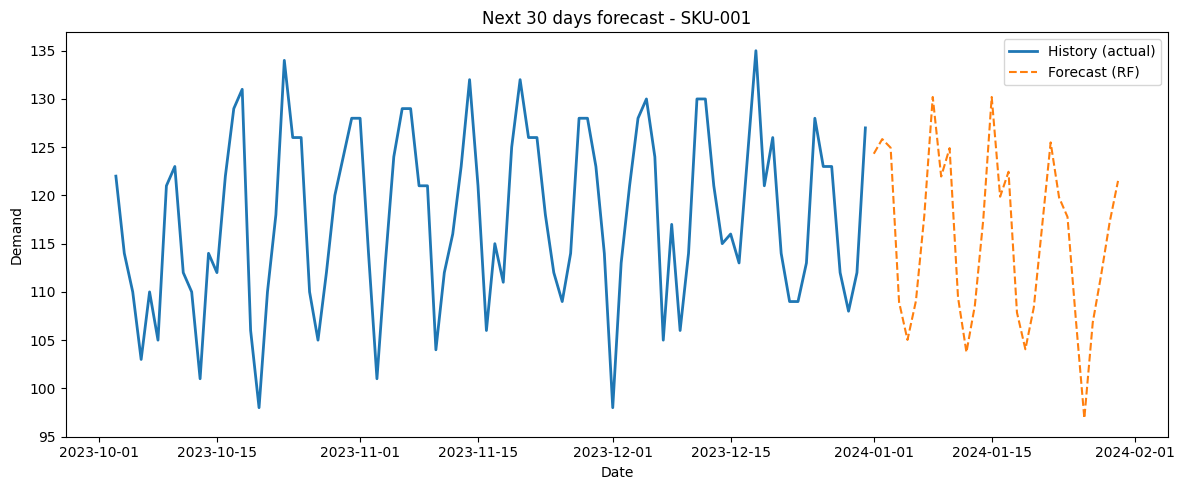

In [16]:
# Plot the last 90 days of history + next 30 days forecast
history_tail = history.tail(90).copy()

plt.figure(figsize=(12,5))
plt.plot(history_tail["date"], history_tail["demand"], label="History (actual)", linewidth=2)
plt.plot(future_df["date"], future_df["forecast_rf"], label="Forecast (RF)", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Next 30 days forecast - SKU-001")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Features and target
X = df2[["demand_lag1", "demand_ma7"]]
y = df2["demand"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# --- Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# --- Random Forest ---
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# Metrics
def metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    return mae, rmse

lr_mae, lr_rmse = metrics(y_test, lr_preds)
rf_mae, rf_rmse = metrics(y_test, rf_preds)

lr_mae, lr_rmse, rf_mae, rf_rmse


(6.8825322457000455,
 np.float64(8.237705717470547),
 10.16701388888889,
 np.float64(11.835145679876057))

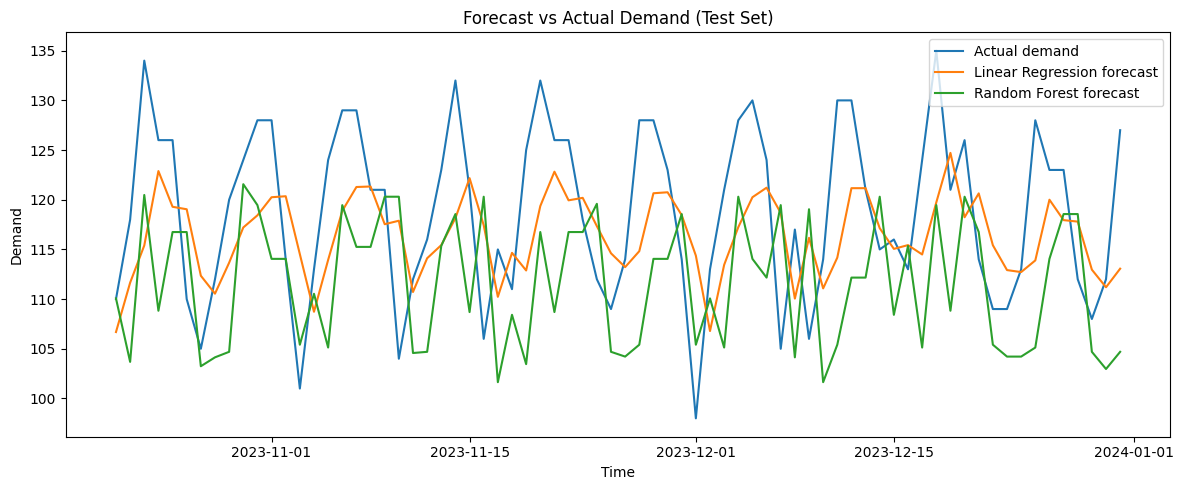

In [18]:
import matplotlib.pyplot as plt

# Use the test indices to line up dates with predictions
test_index = X_test.index

# this will use real dates on the x-axis
if "date" in df2.columns:
    x_axis = df2.loc[test_index, "date"]
else:
    # fallback: uses the index numbers
    x_axis = test_index

plt.figure(figsize=(12, 5))
plt.plot(x_axis, y_test.values, label="Actual demand")
plt.plot(x_axis, lr_preds, label="Linear Regression forecast")
plt.plot(x_axis, rf_preds, label="Random Forest forecast")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("Forecast vs Actual Demand (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()
